In [17]:
import tqdm
import pandas as pd 
import numpy as np 
import os
from itertools import chain
from sklearn.model_selection import train_test_split

In [32]:
import tensorflow as tf

In [59]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [19]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU') 
        print(gpus[0].name)
    except RuntimeError as e:
        print(e)

/physical_device:GPU:0


In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

In [21]:
img_labels_df = pd.read_csv('data/image_labels.csv')

img_labels_df.head()

,img_name,diagnosis,follow_up_num,patient_id,patient_age,patient_gender,view_position,original_width,original_height,original_x_spacing,original_y_spacing
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [22]:
all_diagnoses = list(set(chain(*img_labels_df['diagnosis'].map(lambda x: x.split('|')).tolist())))
for diagnosis in all_diagnoses:
    img_labels_df[diagnosis] = img_labels_df['diagnosis'].map(lambda diagnoses: diagnosis in diagnoses)

diagnosis_counts = {diagnosis: img_labels_df[diagnosis].sum() for diagnosis in all_diagnoses}

print(f"Dataframe Shape: {img_labels_df.shape}")
img_labels_df.head(10)

Dataframe Shape: (112120, 26)


,img_name,diagnosis,follow_up_num,patient_id,patient_age,patient_gender,view_position,original_width,original_height,original_x_spacing,...,Consolidation,Fibrosis,Emphysema,Infiltration,Atelectasis,Pneumonia,Mass,No Finding,Pneumothorax,Cardiomegaly
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,...,False,False,False,False,False,False,False,False,False,True
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,False,False,True,False,False,False,False,False,False,True
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,False,False,False,False,False,False,False,False,False,True
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,...,False,False,False,False,False,False,False,True,False,False
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,...,False,False,False,False,False,False,False,False,False,False
5,00000003_002.png,Hernia,1,3,75,F,PA,2048,2500,0.168,...,False,False,False,False,False,False,False,False,False,False
6,00000003_003.png,Hernia|Infiltration,2,3,76,F,PA,2698,2991,0.143,...,False,False,False,True,False,False,False,False,False,False
7,00000003_004.png,Hernia,3,3,77,F,PA,2500,2048,0.168,...,False,False,False,False,False,False,False,False,False,False
8,00000003_005.png,Hernia,4,3,78,F,PA,2686,2991,0.143,...,False,False,False,False,False,False,False,False,False,False
9,00000003_006.png,Hernia,5,3,79,F,PA,2992,2991,0.143,...,False,False,False,False,False,False,False,False,False,False


In [23]:
img_labels_df['vectorized_diagnoses'] = img_labels_df.apply(lambda x: [x[all_diagnoses].values], 1).map(lambda x: [float(val) for val in x[0]])
img_labels_df["img_path"] = img_labels_df['img_name'].apply(lambda x: "./data/images/" + x)
img_labels_df['split_diagnoses'] = img_labels_df.apply(lambda x: x['diagnosis'].split('|'), axis=1)

In [24]:
split: list[pd.DataFrame] = train_test_split(img_labels_df, test_size=0.15, random_state=2003)
training_df, validation_df = split
print(f"Training Size: {len(training_df)}\nValidation Size: {len(validation_df)}")

Training Size: 95302
Validation Size: 16818


In [25]:
training_df.sample(10)

,img_name,diagnosis,follow_up_num,patient_id,patient_age,patient_gender,view_position,original_width,original_height,original_x_spacing,...,Infiltration,Atelectasis,Pneumonia,Mass,No Finding,Pneumothorax,Cardiomegaly,vectorized_diagnoses,img_path,split_diagnoses
77220,00018972_013.png,No Finding,13,18972,52,F,AP,2500,2048,0.168000,...,False,False,False,False,True,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00018972_013.png,[No Finding]
2838,00000756_000.png,No Finding,4,756,50,M,PA,1864,2021,0.194311,...,False,False,False,False,True,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00000756_000.png,[No Finding]
23899,00006297_005.png,Effusion,5,6297,46,F,PA,2048,2500,0.168000,...,False,False,False,False,False,False,False,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00006297_005.png,[Effusion]
98150,00025917_000.png,No Finding,0,25917,21,M,PA,3056,2544,0.139000,...,False,False,False,False,True,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00025917_000.png,[No Finding]
102653,00027364_000.png,No Finding,0,27364,53,M,PA,2021,2021,0.194311,...,False,False,False,False,True,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00027364_000.png,[No Finding]
44380,00011420_016.png,No Finding,14,11420,68,F,PA,2992,2991,0.143000,...,False,False,False,False,True,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00011420_016.png,[No Finding]
100615,00026709_000.png,Infiltration|Nodule,0,26709,66,M,PA,2992,2991,0.143000,...,True,False,False,False,False,False,False,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...",./data/images/00026709_000.png,"[Infiltration, Nodule]"
90477,00022526_014.png,No Finding,0,22526,47,F,PA,2714,2557,0.143000,...,False,False,False,False,True,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00022526_014.png,[No Finding]
92249,00023053_000.png,Effusion,0,23053,34,M,PA,2992,2991,0.143000,...,False,False,False,False,False,False,False,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00023053_000.png,[Effusion]
78005,00019151_000.png,Infiltration|Nodule,0,19151,58,F,PA,2070,2991,0.143000,...,True,False,False,False,False,False,False,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...",./data/images/00019151_000.png,"[Infiltration, Nodule]"


In [26]:
validation_df.sample(10)

,img_name,diagnosis,follow_up_num,patient_id,patient_age,patient_gender,view_position,original_width,original_height,original_x_spacing,...,Infiltration,Atelectasis,Pneumonia,Mass,No Finding,Pneumothorax,Cardiomegaly,vectorized_diagnoses,img_path,split_diagnoses
66637,00016484_011.png,No Finding,10,16484,6,F,PA,2992,2991,0.143000,...,False,False,False,False,True,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00016484_011.png,[No Finding]
20795,00005556_005.png,Effusion,5,5556,50,F,AP,2500,2048,0.168000,...,False,False,False,False,False,False,False,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00005556_005.png,[Effusion]
34347,00009021_013.png,No Finding,13,9021,19,F,PA,2992,2991,0.143000,...,False,False,False,False,True,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00009021_013.png,[No Finding]
47664,00012089_010.png,No Finding,10,12089,40,M,PA,2992,2991,0.143000,...,False,False,False,False,True,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00012089_010.png,[No Finding]
36639,00009644_032.png,No Finding,32,9644,74,M,PA,2500,2048,0.168000,...,False,False,False,False,True,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00009644_032.png,[No Finding]
39830,00010406_005.png,No Finding,5,10406,17,M,AP,2500,2048,0.168000,...,False,False,False,False,True,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00010406_005.png,[No Finding]
108361,00029363_000.png,No Finding,0,29363,61,M,PA,2021,2021,0.194311,...,False,False,False,False,True,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00029363_000.png,[No Finding]
50818,00012863_002.png,Atelectasis,1,12863,39,F,AP,2500,2048,0.168000,...,False,True,False,False,False,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00012863_002.png,[Atelectasis]
41727,00010772_003.png,Effusion,3,10772,70,M,PA,2818,2865,0.143000,...,False,False,False,False,False,False,False,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00010772_003.png,[Effusion]
77695,00019092_003.png,No Finding,9,19092,50,F,PA,2544,3056,0.139000,...,False,False,False,False,True,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00019092_003.png,[No Finding]


In [50]:
idg_parameterized = ImageDataGenerator(height_shift_range= 0.07,
                                  width_shift_range=0.12,
                                  rotation_range=5,
                                  zoom_range=0.17,
                                  shear_range = 0.12,
                                  horizontal_flip = True,
                                  vertical_flip = False,
                                  samplewise_center=True, 
                                  samplewise_std_normalization=True, 
                                  fill_mode = 'reflect',
                                )
img_dimensions = (128, 128)

In [51]:
training_gen = idg_parameterized.flow_from_dataframe(dataframe=training_df, 
                             directory=None,
                             x_col = "img_path",
                            y_col = 'split_diagnoses', 
                             class_mode = 'categorical',
                            classes = all_diagnoses,
                            target_size = img_dimensions,
                             color_mode = 'grayscale',
                            batch_size = 32)

Found 95302 validated image filenames belonging to 15 classes.


In [52]:
validation_gen = idg_parameterized.flow_from_dataframe(dataframe=validation_df, 
                             directory=None,
                             x_col = 'img_path',
                            y_col = 'split_diagnoses', 
                             class_mode = 'categorical',
                            classes = all_diagnoses,
                            target_size = img_dimensions,
                             color_mode = 'grayscale',
                            batch_size = 256)

Found 16818 validated image filenames belonging to 15 classes.


In [53]:
t_X, t_Y = next(idg_parameterized.flow_from_dataframe(dataframe=training_df, 
                             directory=None,
                             x_col = 'img_path',
                            y_col = 'split_diagnoses', 
                             class_mode = 'categorical',
                            classes = all_diagnoses,
                            target_size = img_dimensions,
                             color_mode = 'grayscale',
                            batch_size = 1024))

Found 95302 validated image filenames belonging to 15 classes.


In [54]:
v_X, v_Y = next(idg_parameterized.flow_from_dataframe(dataframe=validation_df, 
                             directory=None,
                             x_col = 'img_path',
                            y_col = 'split_diagnoses', 
                             class_mode = 'categorical',
                            classes = all_diagnoses,
                            target_size = img_dimensions,
                             color_mode = 'grayscale',
                            batch_size = 1024))

Found 16818 validated image filenames belonging to 15 classes.


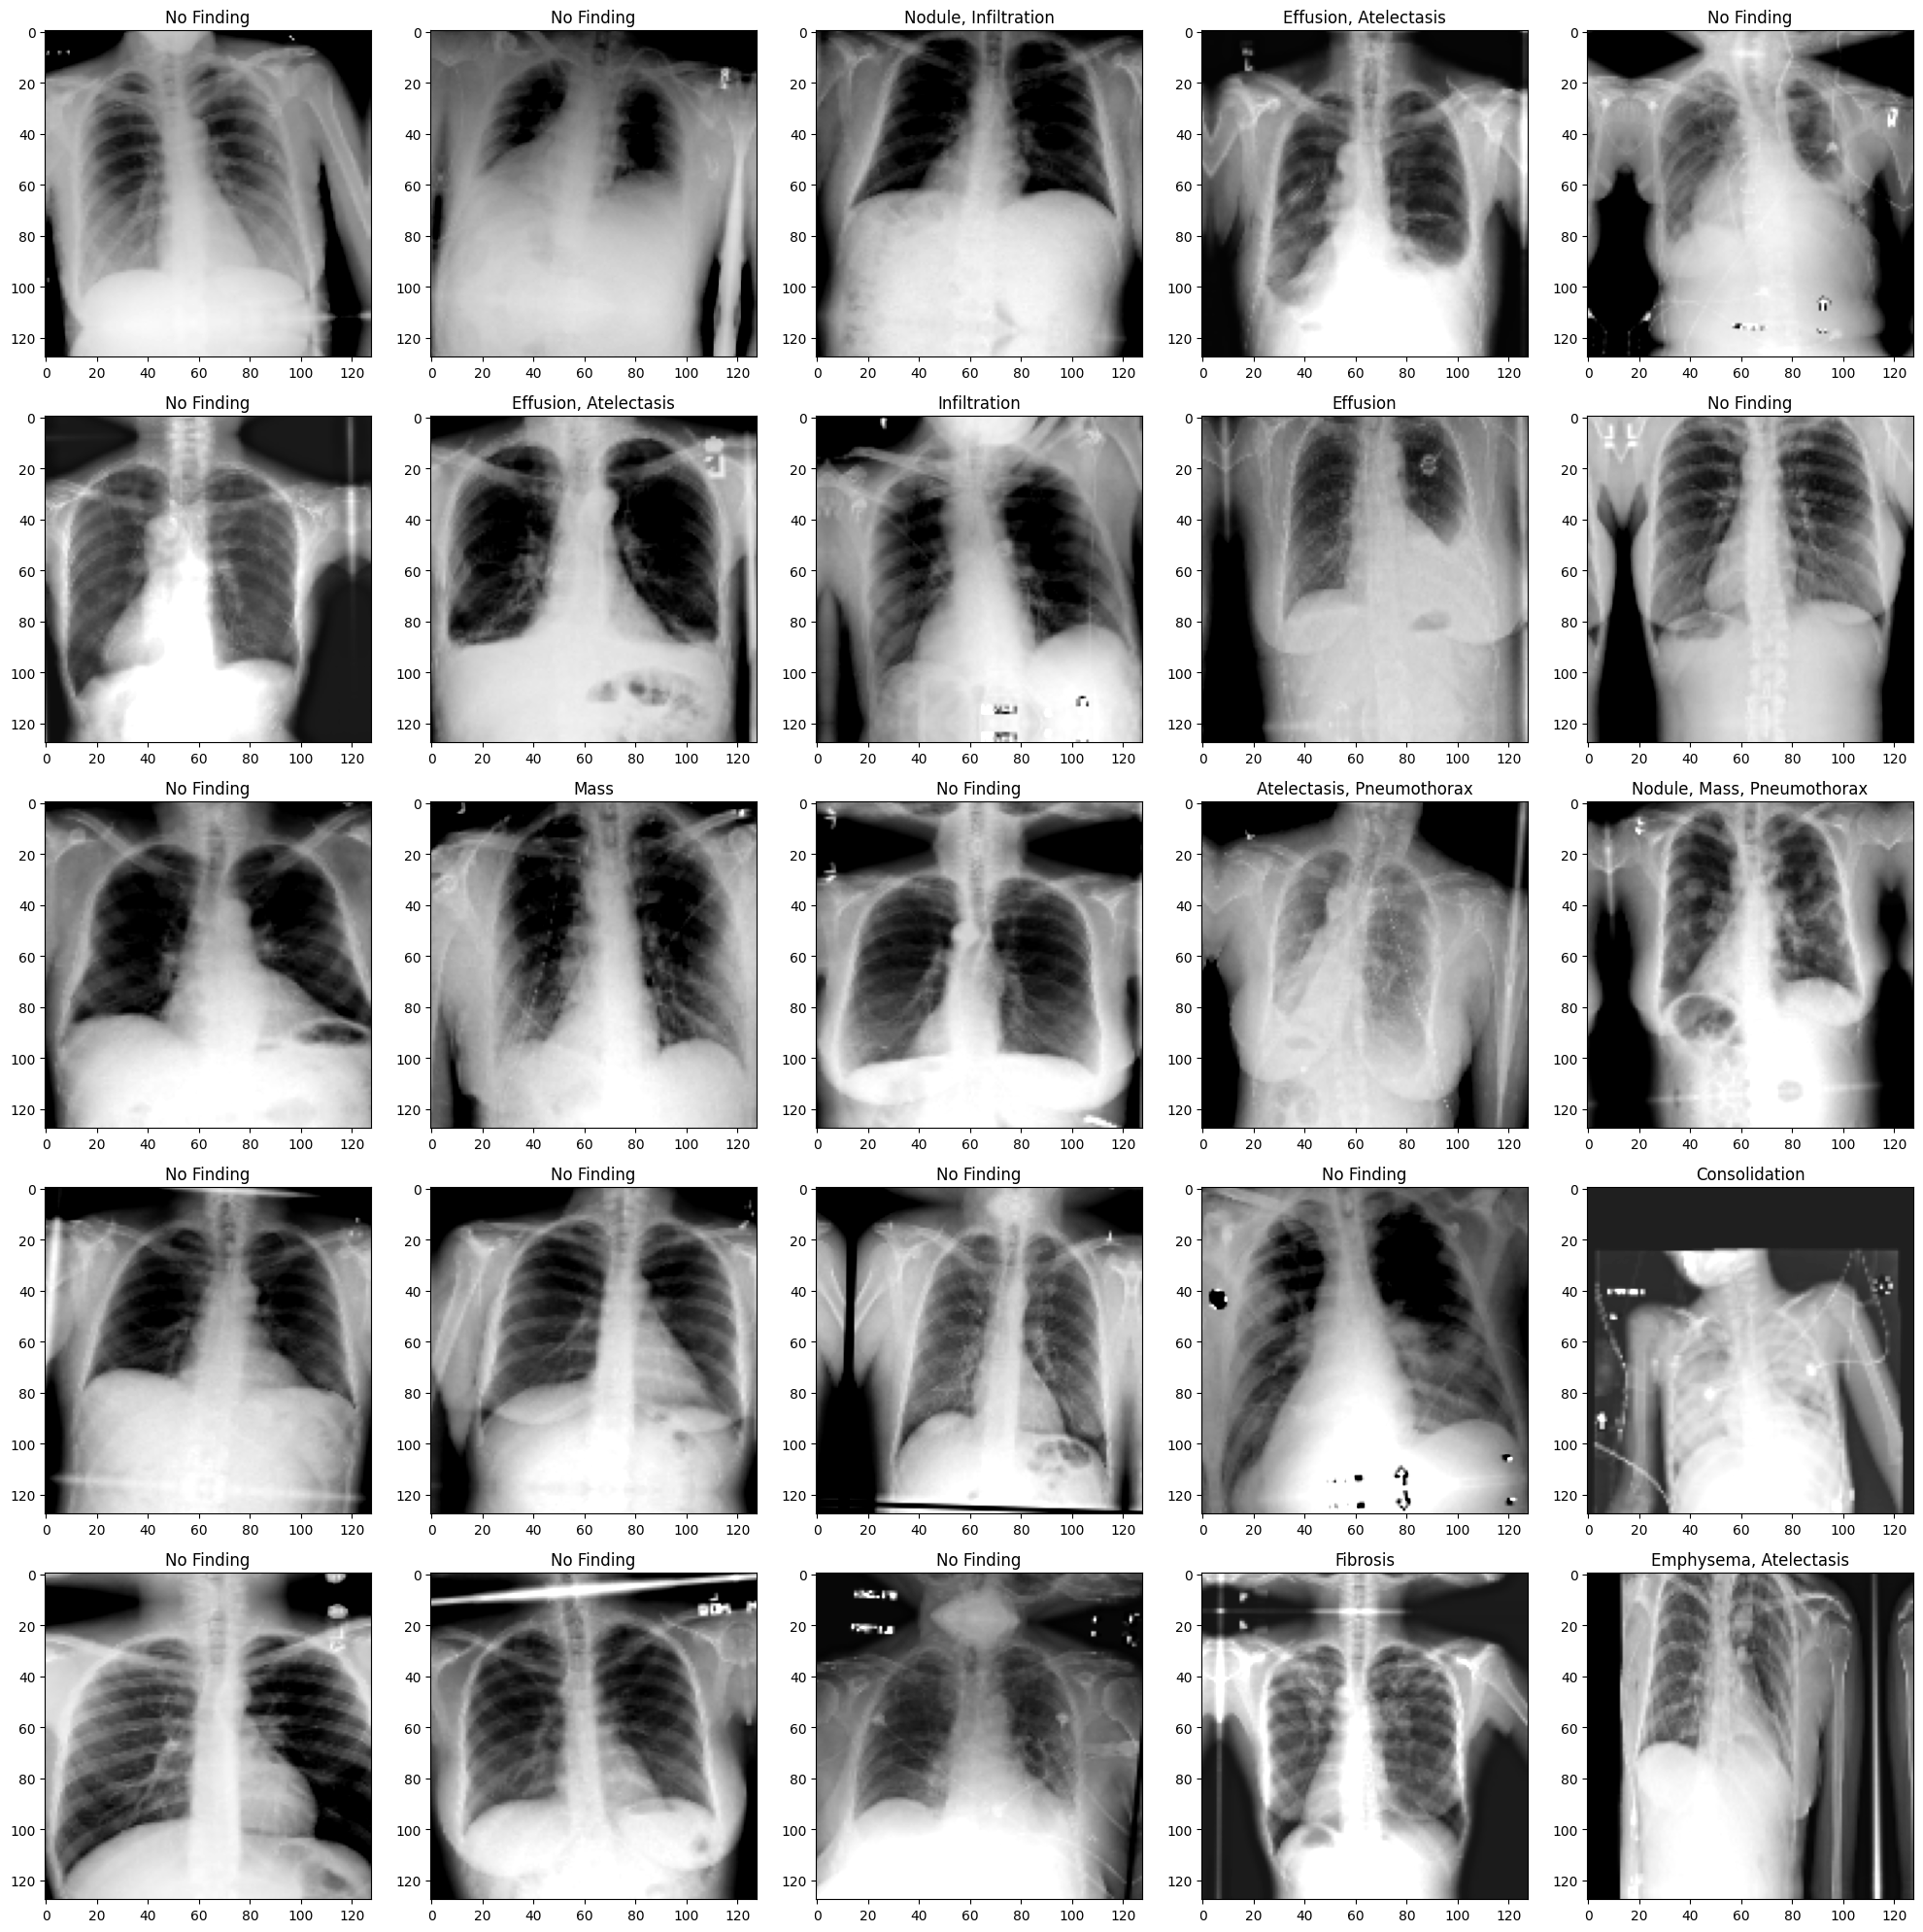

In [58]:
grid_size = 5

tr_x, tr_y = next(training_gen)

fig, matrix_axs = plt.subplots(grid_size, grid_size, figsize=(grid_size * 4, grid_size * 4))
for (img, labels, ax) in zip(tr_x, tr_y, matrix_axs.flatten()):
    ax.imshow(img[:, :, 0], cmap='gist_gray', vmin=-1.5, vmax=1.5)
    title = ', '.join([diagnosis for diagnosis, score in zip(all_diagnoses, labels) if score > 0.5])
    ax.set_title(title)

plt.tight_layout()
plt.show()

In [67]:
mnet_model = MobileNet(input_shape = tr_x.shape[1:], 
                                 include_top = False, weights = None)

MULTI_DIAGNOSIS_MODEL_PARAMETERS = {
    "DROPOUT": 0.5,
    "DENSE": 512,
    "ACTIVATION": 'sigmoid',
    "OPTIMIZER": 'adam',
    "LOSS": 'binary_crossentropy',
    "METRICS": ['binary_accuracy', 'mae']
}

In [68]:
multi_disease_model = Sequential()
multi_disease_model.add(mnet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(MULTI_DIAGNOSIS_MODEL_PARAMETERS["DROPOUT"]))
multi_disease_model.add(Dense(MULTI_DIAGNOSIS_MODEL_PARAMETERS["DENSE"]))
multi_disease_model.add(Dropout(MULTI_DIAGNOSIS_MODEL_PARAMETERS["DROPOUT"]))
multi_disease_model.add(Dense(len(all_diagnoses), activation = MULTI_DIAGNOSIS_MODEL_PARAMETERS["ACTIVATION"]))
multi_disease_model.compile(optimizer = MULTI_DIAGNOSIS_MODEL_PARAMETERS["OPTIMIZER"], loss = MULTI_DIAGNOSIS_MODEL_PARAMETERS["LOSS"],
                           metrics = MULTI_DIAGNOSIS_MODEL_PARAMETERS["METRICS"])
multi_disease_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 15)               